## Imports

In [1]:
# modify from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU, Embedding
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [24]:
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
K.tensorflow_backend.set_session(tf.Session(config=config))

## Load Data

path format :
    - /img/ -- contain images
    - /cache/ -- contain cache
    - /caption.json -- contain caption
    - /train.txt -- contain list of filename train
    - /val.txt -- contain list of filename validation

format caption.json :
    - {
        'filename': 000123.jpg
        'captions': [
            {'id': 'Bahasa Indonesia',
             'en' : 'English'},
            ...
        ],
        'emotions': {
            'happy': 'Emosi happy',
            'sad': 'Emosi sad',
            'angry': 'Emosi angry'
        }
      }

In [9]:
from preparation import convert_mongo, split_and_save, load_caption

path = './dataset'
flickr_folder = path + '/flickr10k'
coco_folder = path + '/mscoco'

# # convert mongo to caption dict
# caption_flickr, caption_coco = convert_mongo(path=path + '/caption_bc.json')

# # save
# with open(flickr_folder + '/caption.json', 'w') as f:
#     json.dump(caption_flickr, f)
# with open(coco_folder + '/caption.json', 'w') as f:
#     json.dump(caption_coco, f)

# split_and_save(caption_flickr, flickr_folder)
# split_and_save(caption_coco, coco_folder)

train, val = load_caption(flickr_folder)
filenames_train, captions_train = train
filenames_val, captions_val = val
num_images_train = len(filenames_train)
num_images_train

9000

### Loading and Showing Images

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from images import load_image

In [13]:
def show_image(idx, folder_path, train):

    if train:
        filename = filenames_train[idx]
        captions = captions_train['factual'][idx]
    else:
        filename = filenames_val[idx]
        captions = captions_val['factual'][idx]

    path = folder_path + '/img/' + filename

    for caption in captions:
        print(caption)

    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Seorang lelaki mengenakan celana pendek dan kemeja Hawaii bersandar di atas rel perahu pilot, dengan kabut dan pegunungan di latar belakang.
Seorang pria muda yang tergantung di sisi perahu, yang dalam kondisi seperti kabut berguling di atas bukit di belakangnya.
Seorang pria bersandar di sisi perahu biru dan putih saat ia duduk di badan air.
Seorang pria menaiki perahu kecil di pelabuhan, dengan kabut dan pegunungan di latar belakang.
Seorang lelaki di atas perahu biru dan putih yang ditambatkan dengan bukit-bukit dan kabut di latar belakang.


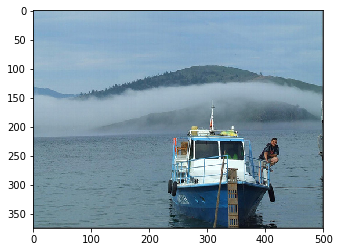

In [14]:
show_image(idx=0, folder_path=flickr_folder, train=True)

## Pre-Trained Image Model (ResNet152)

In [15]:
from model import EncoderResNet152
from keras import backend as K
encoder_resnet152 = EncoderResNet152()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
img_size = K.int_shape(encoder_resnet152.model.input)[1:3]
transfer_values_size = K.int_shape(encoder_resnet152.model.output)[1]
print('img_size', img_size)
print('transfer_values_size', transfer_values_size)

img_size (224, 224)
transfer_values_size 2048


## Load pretrained image

In [17]:
from images import process_images_all

In [18]:
%%time
transfer_values_train = process_images_all(folder_path=flickr_folder, 
                       is_train=True,
                       filenames=filenames_train,
                       img_size=img_size,
                       transfer_values_size=transfer_values_size,
                       image_model_transfer=encoder_resnet152.model,
                       batch_size=64)
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 9000 images in training-set ...
dtype: float16
shape: (9000, 2048)
CPU times: user 13.2 ms, sys: 34.4 ms, total: 47.5 ms
Wall time: 47 ms


In [19]:
%%time
transfer_values_val = process_images_all(folder_path=flickr_folder, 
                       is_train=False,
                       filenames=filenames_val,
                       img_size=img_size,
                       transfer_values_size=transfer_values_size,
                       image_model_transfer=encoder_resnet152.model,
                       batch_size=64)
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 1000 images in validation-set ...
dtype: float16
shape: (1000, 2048)
CPU times: user 3.13 ms, sys: 6.78 ms, total: 9.91 ms
Wall time: 9.15 ms


## Tokenizer

In [25]:
from tokenizer import mark_captions, flatten, TokenizerWrap, mark_start, mark_end

In [65]:
%%time
num_words = 10000
modes = ['happy', 'sad', 'angry']
captions_train_flat_all = []
for mode in ['factual'] + modes:
    captions_train_marked = mark_captions(captions_train[mode])
    captions_train_flat = flatten(captions_train_marked)
    tokenizer = TokenizerWrap(texts=captions_train_flat,num_words=num_words)
    # remove oov words
    tmp = tokenizer.texts_to_sequences(captions_train_flat)
    captions_train_flat = tokenizer.sequences_to_texts(tmp)
    captions_train_flat_all.extend(captions_train_flat)
tokenizer = TokenizerWrap(texts=captions_train_flat_all)
num_words = len(tokenizer.word_index)
print(num_words)

10730
CPU times: user 3.35 s, sys: 65.6 ms, total: 3.41 s
Wall time: 3.44 s


In [53]:
%%time
captions_train_marked = mark_captions(captions_train['sad'])
captions_train_flat = flatten(captions_train_marked)
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 113 ms, sys: 12.7 ms, total: 125 ms
Wall time: 124 ms


In [54]:
token_start = tokenizer.word_index[mark_start.strip()]
token_end = tokenizer.word_index[mark_end.strip()]
print('token_start', token_start)
print('token_end', token_end)

token_start 1
token_end 2


## Data Generator

In [55]:
from generator import batch_generator

In [56]:
batch_size = 512

In [57]:
generator = batch_generator(batch_size=batch_size,
                            num_images_train=num_images_train,
                            transfer_values_train=transfer_values_train,
                            tokens_train=tokens_train)

### Steps Per Epoch

In [58]:
import numpy as np
num_captions_train = [len(captions) for captions in captions_train['sad']]
total_num_captions_train = np.sum(num_captions_train)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

17

## Create NIC and StyleNet

In [66]:
from model import NIC, StyleNet
state_size = 512
embedding_size = 128
factored_size = 256
nic = NIC(num_words=num_words,
          transfer_values_size=transfer_values_size,
          state_size=state_size,
          embedding_size=embedding_size)
stylenet = StyleNet(mode='sad',
                    num_words=num_words,
                    transfer_values_size=transfer_values_size,
                    state_size=state_size,
                    embedding_size=embedding_size,
                    factored_size=factored_size)

### Callback Functions

In [67]:
from callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [68]:
path_checkpoint = 'checkpoints/checkpoint.id.keras'
callback_checkpoint = ModelCheckpoint(stylenet,
                                      filepath=path_checkpoint)
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [69]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [70]:
try:
    stylenet.load(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoints/checkpoint.id.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

In [71]:
%%time
stylenet.model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

Epoch 1/20
 2/17 [==>...........................] - ETA: 1:24 - loss: 9.2829

KeyboardInterrupt: 

## Generate Captions

In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start
    output_text = ''
    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)

        output_text += " " + sampled_word
        
        count_tokens += 1

    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    
    print("Predicted caption:")
    print(output_text)
    print()

### Examples

In [ ]:
generate_caption(flickr_folder + '/img/' + filenames_train[0])

In [ ]:
generate_caption(flickr_folder + '/img/' + filenames_val[0])

In [ ]:
def generate_caption_all(folder_path, idx, train=False):
    if train:
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = folder_path + '/img/' + filename

    generate_caption(path)

    print("True captions:")
    for caption in captions:
        print(caption)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=1, train=True)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=10, train=True)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=1, train=False)

In [ ]:
from model import StyleNet, ModelCheckpoint